In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
#import cartopy.feature as cfeat
#import cartopy.io.img_tiles as cimgt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#import AISMapPlot as aismap
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [11]:
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
test = pd.read_csv('rot_ham.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [13]:
ais_nan = test
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [19]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan
# Set invalid breadths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)
ais_test= ais_dropped
# Add time for the entire trip to the data
ais_test['TravelTime'] = ais_test['EndTime'] - ais_test['StartTime']
ais_test['TravelTimeMins'] = ais_test['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_test['remainingTT'] = ais_test['EndTime'] - ais_test['time']
ais_test['remainingMins'] = ais_test['remainingTT'].transform(lambda x : x.total_seconds() / 60)
ais_test = ais_test[['Latitude', 'Longitude', 'COG', 'SOG', 'remainingMins']]

In [29]:
ais_test= ais_test.dropna()

In [8]:
ais_learners = []
sectors = [0, 1, 2, 3, 4, 5]
sector_borders = [52.8, 4.8, 6.0, 7.2, 8.6, 9.81]
positions = pd.DataFrame([[52.8, np.nan], [np.nan, 4.8], [np.nan, 6.0], [np.nan, 7.2], [np.nan, 8.6], [np.nan, 9.81]],
                         columns = ['Latitude', 'Longitude'])
for s in sectors:
    ais_learners.append(pd.read_pickle('ROT-HAM_learners_01min_s%d.pkl' % (s)))

In [12]:
complete = ais_learners[0]
complete = complete.append(ais_learners[1])
complete = complete.append(ais_learners[2])
complete = complete.append(ais_learners[3])
complete = complete.append(ais_learners[4])
complete = complete.append(ais_learners[5])

In [16]:
X = complete[['Latitude', 'Longitude', 'COG', 'SOG']]
y = complete['remainingMins']

In [22]:

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = complete['TripID']))


In [23]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [24]:
knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(5, 40), weights = [ 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 5)
knn_rand.fit(X, y)

pd.DataFrame(knn_rand.cv_results_).transpose()

KeyboardInterrupt: 

In [25]:
pd.DataFrame(knn_rand.cv_results_).transpose()

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [40]:
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(ais_test[['Latitude', 'Longitude', 'COG', 'SOG']])

In [41]:
knn_predicts_diffs = knn_predicts - ais_test['remainingMins']

In [42]:
knn_predicts_frame = pd.DataFrame({'correct': ais_test['remainingMins'], 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

count    1422.000000
mean       90.296477
std        62.823463
min         1.000000
25%        76.000000
50%        76.000000
75%        76.000000
max       539.673788
Name: abs_error, dtype: float64

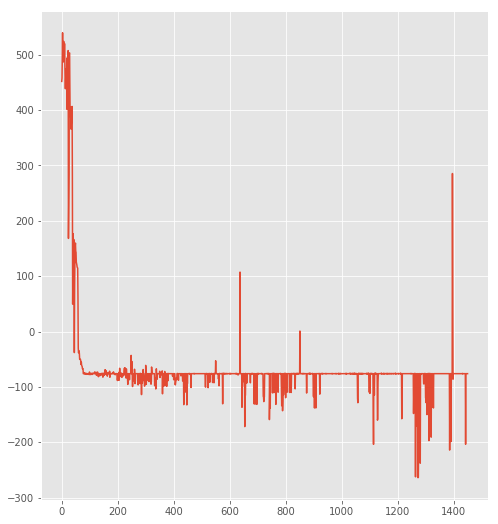

In [43]:
plt.figure(figsize = (8, 9))
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])
#plt.savefig('../Images/rot_ham_complete_test.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

pd.DataFrame(rfo_rand.cv_results_)